In [ ]:
# - 项目内容：
    - 1、二手房信息爬取
    - 2、进行数据预处理
    - 3、进行数据可视化
    - 4、构建机器学习房价预测模型
    - 5、预测房价

# 1、房屋信息的爬取

In [3]:
import requests
from bs4 import BeautifulSoup

def get_house(url):
    '获取页面中每个房子的信息'
    information = {} # 存储房屋所有信息
    res = requests.get(url)
    soup = BeautifulSoup(res.text,'html.parser')
    
    # 获取户型、建筑面积、单价、朝向、楼层、装修情况
    houses = soup.select('.tab-cont-right .trl-item1') 
    for house in houses:
        m = house.text.strip().split('\n')
        me = m[1]
        if '朝向' in me:
            me = me.strip('进门') 
        if '楼层'in me:
            me = me[0:2]
        if '地上层数' in me:
            me = '楼层'
        if '装修程度' in me:
            me = '装修'
        information[me] = m[0].strip()
    
    # 获取小区名字
    name = soup.select('.rcont .blue')
    information['小区名称'] = name[0].text
    
    # 获取房屋总价
    price = soup.select('.trl-item')
    information['房屋总价'] = price[0].text
    return information


In [4]:
import pandas as pd
import time

def get_page(i):
    '分页爬取数据'
    url = r'https://xm.esf.fang.com/house-a0352/i3{}/'.format(i) # 总共多少页
    res = requests.get(url)
    houses = BeautifulSoup(res.text,'html.parser')
    #print(url)
    j  = 1
    houses = houses.select('.shop_list .clearfix h4 a')
    page_information = [] # 数据存储
    for house in houses:
        try:
            demo_url = house['href']
            url = r'https://xm.esf.fang.com' + demo_url + '?channel=1,2&psid=1_{}_60'.format(j) # 每一页中有多少套房子
            # 获取当前页中每套房子的信息
            information = get_house(url)
            print('正在爬取第{}页第{}套房子···'.format(i,j),end='\r')
            page_information.append(information)
            j += 1
            time.sleep(0.5) # 预防爬取频繁，防止ip被封
        except Exception as e:
            print('-------->',e)
    #将爬取的数据转换为DataFrame格式
    df = pd.DataFrame(page_information)
    #df.to_csv('house.csv')
    return df


In [ ]:
# 正式爬取数据并保存为csv数据

df = pd.DataFrame() # 创建一个空的DataFrame
name_csv = 'house'
for i in range(1,101): # 总共爬取100页数据
    try:
        df_get = get_page(i)
        df = df.append(df_get)
        print(df)
    except Exception as e:
        print('------->',e)
    if i/100 == 1:
        df.to_csv(name_csv+str(i)+'.csv')
        df = pd.DataFrame() # 清空当前爬取完成的数据，防止内存溢出

# 2、数据预处理

In [33]:
import numpy as np
import pandas as pd

In [76]:
data = pd.read_csv(r'house.csv') # 如果用pandas打不开数据，可以使用记事本打开把编码格式改成utf-8另存
data.head(7)

,index,单价,小区名称,建筑面积,户型,房屋总价,朝向,楼层,装修
0,0,41117元/平米,仙岳山庄,104.58平米,2室2厅2卫,430万,南北,低层,简装修
1,1,63489元/平米,禹洲华侨海景城,201.61平米,5室2厅2卫,1280万,东北,高层,豪华装修
2,2,58339元/平米,汇丰家园,128.56平米,3室2厅2卫,750万,南北,中层,中装修
3,3,46739元/平米,嘉盛豪园,92平米,3室2厅1卫,430万,南北,中层,精装修
4,4,43952元/平米,金帝花园,118.31平米,3室2厅2卫,520万,南北,高层,简装修
5,5,43245元/平米,摩登时代,48.56平米,1室1厅1卫,210万,东,中层,简装修
6,6,39667元/平米,金榜铁路家园,60平米,2室1厅1卫,238万,南北,高层,简装修


In [38]:
data.drop('index',axis=1,inplace=True) # 删除index列
data.head()

,单价,小区名称,建筑面积,户型,房屋总价,朝向,楼层,装修
0,41117元/平米,仙岳山庄,104.58平米,2室2厅2卫,430万,南北,低层,简装修
1,63489元/平米,禹洲华侨海景城,201.61平米,5室2厅2卫,1280万,东北,高层,豪华装修
2,58339元/平米,汇丰家园,128.56平米,3室2厅2卫,750万,南北,中层,中装修
3,46739元/平米,嘉盛豪园,92平米,3室2厅1卫,430万,南北,中层,精装修
4,43952元/平米,金帝花园,118.31平米,3室2厅2卫,520万,南北,高层,简装修


In [39]:
# Series的extract支持正则匹配抽取，返回的值是字符串
data[['室','厅','卫']] = data['户型'].str.extract(r'(\d+)室(\d+)厅(\d+)卫')

In [40]:
# 把字符串格式转化为float，并删除户型
data['室'] = data['室'].astype(float)
data['厅'] = data['厅'].astype(float)
data['卫'] = data['卫'].astype(float)
del data['户型']
data.head(3)

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117元/平米,仙岳山庄,104.58平米,430万,南北,低层,简装修,2.0,2.0,2.0
1,63489元/平米,禹洲华侨海景城,201.61平米,1280万,东北,高层,豪华装修,5.0,2.0,2.0
2,58339元/平米,汇丰家园,128.56平米,750万,南北,中层,中装修,3.0,2.0,2.0


In [41]:
# 将建筑面积后的平方米去除，并将数据类型改成浮点型
data['建筑面积'] = data['建筑面积'].map(lambda e:e.replace('平米',''))# Series中的map
data['建筑面积'] = data['建筑面积'].astype(float)
# 将单价后的元/平米去除，并将数据类型改成浮点型
data['单价'] = data['单价'].map(lambda e:e.replace(r'元/平米',''))
data['单价'] = data['单价'].astype(float)
# 将房屋总价后的万去除，并将数据类型改成浮点型
data['房屋总价'] = data['房屋总价'].map(lambda e:e.replace('万',''))
data['房屋总价'] = data['房屋总价'].astype(float)
data.head(3)

,单价,小区名称,建筑面积,房屋总价,朝向,楼层,装修,室,厅,卫
0,41117.0,仙岳山庄,104.58,430.0,南北,低层,简装修,2.0,2.0,2.0
1,63489.0,禹洲华侨海景城,201.61,1280.0,东北,高层,豪华装修,5.0,2.0,2.0
2,58339.0,汇丰家园,128.56,750.0,南北,中层,中装修,3.0,2.0,2.0


In [42]:
# 使用pd.get_dummies() 量化数据
data_chaoxiang = pd.get_dummies(data['朝向'])
data_chaoxiang.head(3)

,东,东北,东南,东西,北,南,南北,暂无,西,西北,西南
0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0


In [43]:
data_louchen = pd.get_dummies(data['楼层'])
data_louchen.head(3)

,中层,低层,高层
0,0,1,0
1,0,0,1
2,1,0,0


In [44]:
data_zhuangxiu = pd.get_dummies(data['装修'])
data_zhuangxiu.head(3)

,中装修,暂无,毛坯,简装修,精装修,豪华装修
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,1,0,0,0,0,0


In [45]:
# 使用pd.concat矩阵拼接，axis=1：水平拼接
data = pd.concat([data,data_chaoxiang,data_louchen,data_zhuangxiu],axis=1) 
# 拼接后的列名
data.columns

Index(['单价', '小区名称', '建筑面积', '房屋总价', '朝向', '楼层', '装修', '室', '厅', '卫', '东',
       '东北', '东南', '东西', '北', '南', '南北', '暂无', '西', '西北', '西南', '中层', '低层',
       '高层', '中装修', '暂无', '毛坯', '简装修', '精装修', '豪华装修'],
      dtype='object')

In [46]:
# 特征筛选，删除不需要的列
del data['小区名称']
del data['朝向']
del data['楼层']
del data['装修']
del data['东西']
del data['南北']
del data['暂无'] # 两列都删除
del data['毛坯'] # 多重共线性问题（线性回归）
del data['中装修']
data.columns

Index(['单价', '建筑面积', '房屋总价', '室', '厅', '卫', '东', '东北', '东南', '北', '南', '西',
       '西北', '西南', '中层', '低层', '高层', '简装修', '精装修', '豪华装修'],
      dtype='object')

In [47]:
data.info() # 发现 室厅卫中 有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5830 entries, 0 to 5829
Data columns (total 20 columns):
单价      5830 non-null float64
建筑面积    5830 non-null float64
房屋总价    5830 non-null float64
室       5748 non-null float64
厅       5748 non-null float64
卫       5748 non-null float64
东       5830 non-null uint8
东北      5830 non-null uint8
东南      5830 non-null uint8
北       5830 non-null uint8
南       5830 non-null uint8
西       5830 non-null uint8
西北      5830 non-null uint8
西南      5830 non-null uint8
中层      5830 non-null uint8
低层      5830 non-null uint8
高层      5830 non-null uint8
简装修     5830 non-null uint8
精装修     5830 non-null uint8
豪华装修    5830 non-null uint8
dtypes: float64(6), uint8(14)
memory usage: 353.1 KB


In [48]:
# 删除缺失值
data.dropna(inplace=True)
data.info()                       # 到这里数据预处理完毕

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5748 entries, 0 to 5829
Data columns (total 20 columns):
单价      5748 non-null float64
建筑面积    5748 non-null float64
房屋总价    5748 non-null float64
室       5748 non-null float64
厅       5748 non-null float64
卫       5748 non-null float64
东       5748 non-null uint8
东北      5748 non-null uint8
东南      5748 non-null uint8
北       5748 non-null uint8
南       5748 non-null uint8
西       5748 non-null uint8
西北      5748 non-null uint8
西南      5748 non-null uint8
中层      5748 non-null uint8
低层      5748 non-null uint8
高层      5748 non-null uint8
简装修     5748 non-null uint8
精装修     5748 non-null uint8
豪华装修    5748 non-null uint8
dtypes: float64(6), uint8(14)
memory usage: 392.9 KB


# 3、数据可视化

In [49]:
data.head(3)

,单价,建筑面积,房屋总价,室,厅,卫,东,东北,东南,北,南,西,西北,西南,中层,低层,高层,简装修,精装修,豪华装修
0,41117.0,104.58,430.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,63489.0,201.61,1280.0,5.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2,58339.0,128.56,750.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


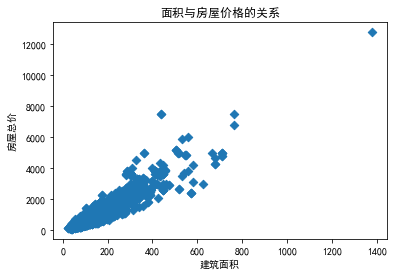

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl
import pylab
from IPython.core.pylabtools import figsize
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
pylab.rcParams['figure.figsize'] = (15.0, 10.0)    #显示图片的大小
%matplotlib inline
area = data['建筑面积']
price = data['房屋总价']
plt.scatter(area,price,marker='D')
plt.xlabel('建筑面积') 
plt.ylabel('房屋总价') 
plt.title('面积与房屋价格的关系')
plt.show() # 有离群点数据，对线性分析不利，需要过滤

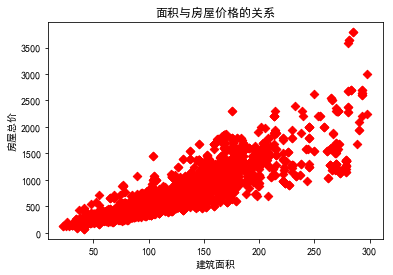

In [51]:
df = data[data['建筑面积'] <=300] # 正常住宅面积小于等于300平米
area = df['建筑面积']
price = df['房屋总价']
#print(area.count()) #过滤后的数据量
plt.scatter(area,price,c='red',marker='D')
plt.xlabel('建筑面积') 
plt.ylabel('房屋总价') 
plt.title('面积与房屋价格的关系')
plt.show()

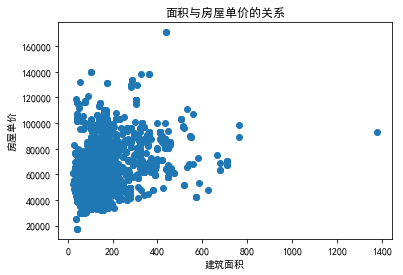

In [54]:
area = data['建筑面积']
price = data['单价']
plt.scatter(area,price)
plt.xlabel('建筑面积') 
plt.ylabel('房屋单价') 
plt.title('面积与房屋单价的关系')
plt.show() 

In [55]:
data.head(1)

,单价,建筑面积,房屋总价,室,厅,卫,东,东北,东南,北,南,西,西北,西南,中层,低层,高层,简装修,精装修,豪华装修
0,41117.0,104.58,430.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


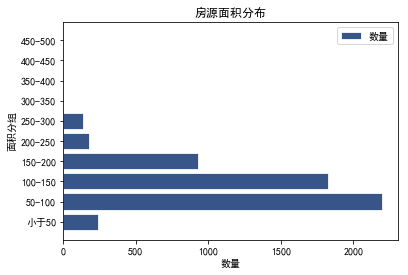

In [77]:
bins = [0, 50, 100, 150, 200, 250, 300, 350,400,450,500]
group_mianji = ['小于50', '50-100', '100-150', '150-200','200-250','250-300','300-350','350-400','400-450','450-500']
df['group_mianji'] = pd.cut(df['建筑面积'], bins, labels=group_mianji)
#按房源面积分组对房源数量进行汇总
group_mianji=df.groupby('group_mianji')['group_mianji'].agg('count')
a = np.array(range(1,11))
plt.barh(list(range(1,11)),group_mianji,color ='#052B6C',alpha = 0.8,edgecolor='white')
plt.xlabel("数量")
plt.ylabel("面积分组")
plt.title('房源面积分布')
plt.legend(['数量'], loc='upper right')
plt.yticks(a,('小于50', '50-100', '100-150', '150-200','200-250','250-300','300-350','350-400','400-450','450-500'))
plt.show()

Text(0.5, 1.0, '房屋总价分布直方图')

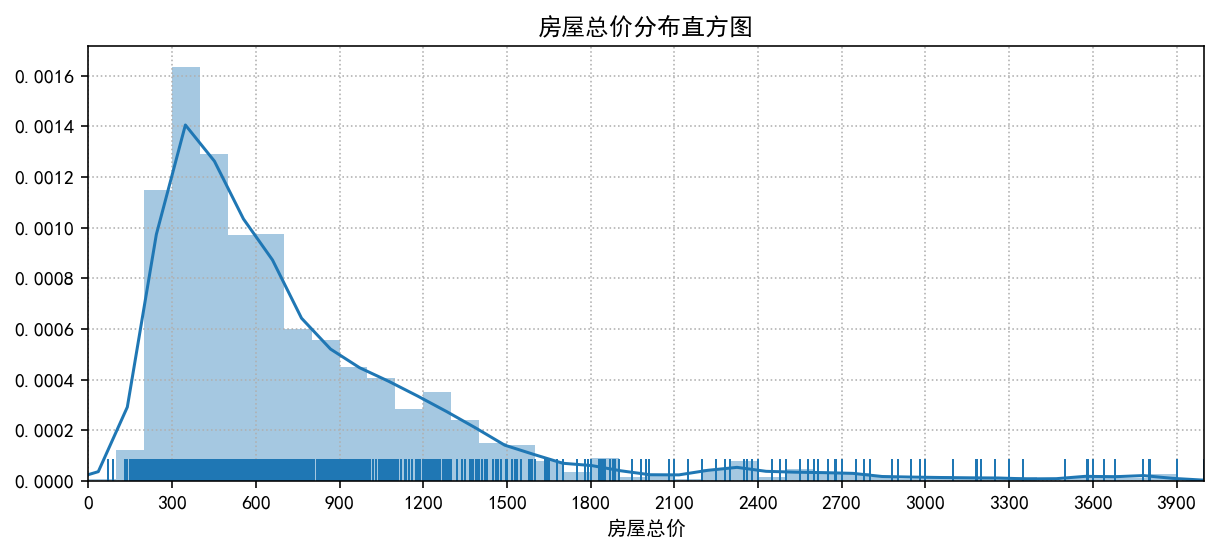

In [70]:
import seaborn as sns
plt.figure(figsize=[10,4],dpi=144)
sns.distplot(data["房屋总价"],bins=range(0,4000,100),rug=True)
plt.xticks(range(0,4000,300))
plt.grid(ls=":")
plt.xlim(0,4000)
plt.title("房屋总价分布直方图")

# 4、构建房价预测模型

In [25]:
# 先根据建筑面积和房屋总价训练模型（一元线性回归）
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
area = np.array(area).reshape(-1,1) # 这里需要注意新版的sklearn需要将数据转换为矩阵才能进行计算
price = np.array(price).reshape(-1,1)
# 训练模型
model = linear.fit(area,price)
# 打印截距和回归系数
print(model.intercept_, model.coef_)

[-267.64092896] [[8.13762926]]


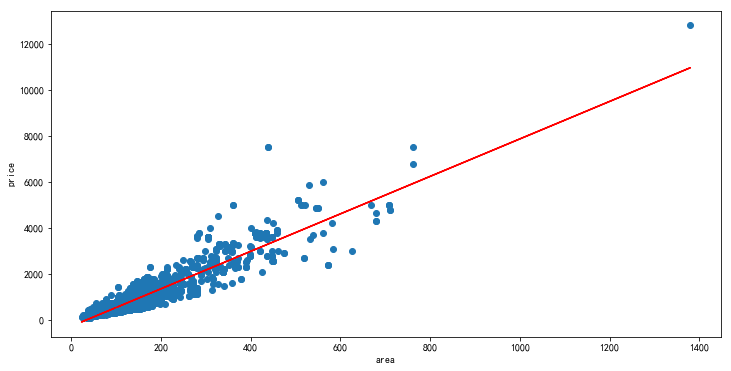

In [26]:
# 线性回归可视化(数据拟合)
linear_p = model.predict(area)
plt.figure(figsize=(12,6))
plt.scatter(area,price)
plt.plot(area,linear_p,'red')
plt.xlabel("area")
plt.ylabel("price")
plt.show()

### 多特征模型训练（多元线性回归）

In [27]:
cols = ['建筑面积','室', '厅', '卫', '东',  '北', '南', '西',
        '低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']

In [28]:
X = df[cols]
X.head()

,建筑面积,室,厅,卫,东,北,南,西,低层,高层,毛坯,简装修,精装修,豪华装修
0,104.58,2.0,2.0,2.0,0,0,0,0,1,0,0,1,0,0
1,201.61,5.0,2.0,2.0,0,0,0,0,0,1,0,0,0,1
2,128.56,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0
3,92.00,3.0,2.0,1.0,0,0,0,0,0,0,0,0,1,0
4,118.31,3.0,2.0,2.0,0,0,0,0,0,1,0,1,0,0


In [29]:
y = df['房屋总价']
y.head()

0     430.0
1    1280.0
2     750.0
3     430.0
4     520.0
Name: 房屋总价, dtype: float64

In [30]:
print(type(X))
print(type(y))
# 使用train_test_split进行交叉验证
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=12)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(4406, 14) (4406,)
(1102, 14) (1102,)


In [31]:
# 模型训练
linear = LinearRegression()
model = linear.fit(x_train,y_train)
print(model.intercept_, model.coef_)

-191.98883969879705 [  6.82886362  32.00891969 -36.97685847   7.62975232  22.99531968
  31.22563871  73.15256729  36.61648837   3.80023165 -10.72026459
  70.35418699  -3.4625147   49.06198269 126.47987378]


In [32]:
# 模型性能评分
price_end = model.predict(x_test)
score = model.score(x_test,y_test) 
print("模型得分：",score)# 一般模型在0.6以上就表现的不错

模型得分： 0.7634014501966522


### 使用多种特征组合都可以预测房价，那么怎么找出最佳组合，这里使用假设验证法，选出最佳特征组合

In [ ]:
# 使用假设验证法，选出最佳特征组合
cols = ['建筑面积','室', '厅', '卫', '东', '东北', '东南', '北', '南', '西',
       '西北', '西南', '低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']
import statsmodels.api as sm
Y = df['房屋总价']
X = df[cols]
X_ = sm.add_constant(X) #增加一列值为1的const列，保证偏置项的正常
#print(X_)
# 使用最小平方法
result = sm.OLS(Y,X_)
# 使用fit方法进行计算
summary = result.fit()
# 调用summary2方法打印出假设验证信息（性能指标）
summary.summary2() # R-squared:模型评分 AIC：组合完越小越好

名词解释

- coef 回归系数
- Std.Err 标准差
- t 虚无假设成立时的t值
- P>|t| 虚无假设成立时的概率值
- [0.025,0.975] 97.5%置信估计区间
- 要做假设性验证，首先要设置显著性标准。
- a.假设显著性标准是0.01
- b.推翻虚无假设的标准是p<0.01
- c.上面的SqFt的t=9.2416，P(>5) = 0.0000 < 0.01,因此虚无假设被推翻（这里的虚无假设是SqFt对price的回归系数为0，即SqFt与price不相关）

F统计
- 回归平方和Regression Square Sum[RSS]:依变量的变化归咎于回归模型A=sum((y-y_)^2
- 误差平方和Error Square Sum[ESS]:依变量的变化归咎于线性模型B=sum((y-y_)^2
- 总的平方和Total Square Sum[TSS]:依变量整体变化C=A+B
- 回归平方平均Model Mean Square:=RSS/Regression d.f(k) k=自变量的数量
- 误差平方平均Error Mean square:=ESS/Error d.f(n-k-1) n=观测值得数量
- F统计F=Model Mean Square /Error Mean Square
- F值越大越好，Prob(F-statistic)越小越好

R Square
- 回归可以解释变量比例，可以作为自变量预测因变量准确度的指标
- SSE(残差平方和) = sum((y-y_)^2)
- SST(整体平方和）= sum((yi-yavg)^2
- R^2 = 1-SEE/SST 一般要大于0.6,0.7才算好

Adjust R Square
- R^2 = 1-SSE/SST SSE最小，推导出R^2不会递减
- yi = b1x1 + b2x2 +...+bkxk+...增加任何一个变量都会增加R^2
- Adj R^2 = 1-(1-R^2) * ((n-1)/(n-p-1))
- n为总体大小，p为回归因子个数

AIC/BIC
- AIC(The Akaike Information Criterion)= 2K + nln(SSE/n) K是参数数量，n是观察数，SSE是残差平方和。
- AIC鼓励数据拟合的优良性，但是应该尽量避免过拟合，所以优先考虑的模型应该是AIC最小的哪一个，
- 赤池信息量的准则是寻找可以最好的解释数据但是包含最少自由参数的模型。

In [ ]:
import itertools

list1 = [1, 2,3, 4, 5,6,7,8,9,10,11,12,13,14,15,16] #特征超过16个将发生异常
list2 = []
for i in range(1, len(list1)+1):
    iter1 = itertools.combinations(list1, i)
    list2.append(list(iter1))
#print(list2)

In [ ]:
import itertools
# 使用itertools，找出AIC最小值的特征组合作为模型训练的特征
# 寻找最小AIC值的特征组合
fileds = ['建筑面积','室', '厅', '卫', '东','北', '南', '西','低层', '高层', '毛坯', '简装修', '精装修', '豪华装修']
acis = {}
for i in range(1,len(fileds)+1):
    for virables in itertools.combinations(fileds,i): #从fileds中随机选择i个特征机型组合，返回的virables为元组类型
        x1 = sm.add_constant(df[list(virables)])
        x2 = sm.OLS(Y,x1)
        res = x2.fit()
        acis[virables] = res.aic # AIC评分越小越好

In [ ]:
from collections import Counter
# 对字典进行统计
counter = Counter(acis)
# 降序选出AIC最小的10个数，也就是最佳特征组合
counter.most_common()[-10:] 

In [ ]:
# 接下来使用AIC值最小的特征组合进行预测
col2 = ['建筑面积', '室', '厅', '东', '南', '高层', '毛坯', '精装修', '豪华装修']
X = df[col2]
y = df['房屋总价']
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
linear = LinearRegression()
model = linear.fit(x_train,y_train)
model.score(x_test,y_test) # 模型性能有所提高，但是提升的不明显

# 5、房价的预测

现在我们可以根据给定的最佳特征组合进行预测房价

In [ ]:
# 假设我要买一套房子（想想就觉得很美），房子面积120平米，3室，1厅，南面，高层，精装修
my_house = [120,3,1,0,1,1,0,1,0] #根据col2特征
my_house = np.array(my_house).reshape(-1,1).T
#print(x_test)
model.predict(my_house)# 预测价格

End···